Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


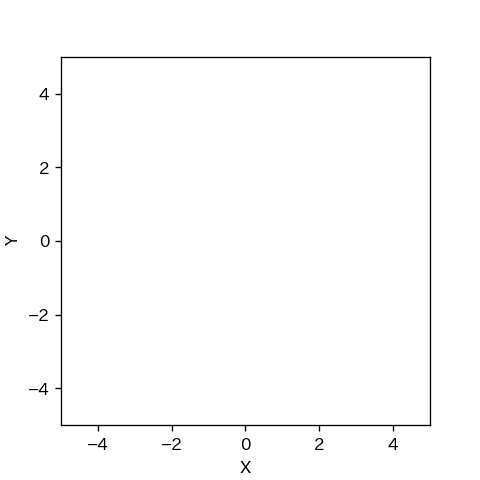

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-2,-2))
    m.append_landmark(Landmark(2,-2))
    m.append_landmark(Landmark(0,2*math.sqrt(3)-2))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-4.0, -2.0), np.random.uniform(-4.0, 4.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


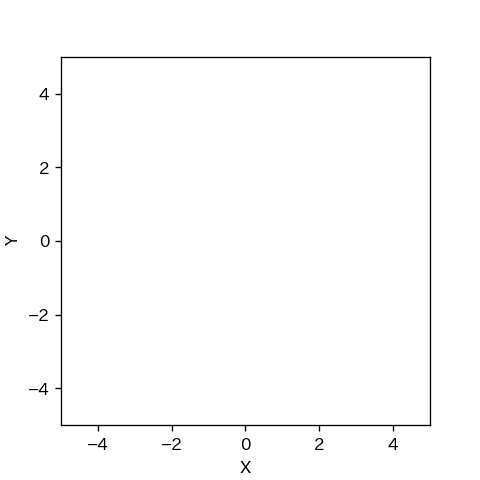

(array([-2.73165297,  1.9010492 , -2.1824263 ]),
 array([ 3.32004097, -2.83261118, -0.4604034 ]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

0 真値: [-3.14666712  0.39896267  7.33942216] 推定値: [-3.1865699   0.5102638   1.01647761] 誤差: 0.11823777803419758
1
1 真値: [-2.86635685 -2.32151633  3.25564031] 推定値: [-2.66485955 -2.24912699  2.82855144] 誤差: 0.2141060055506028
2
2 真値: [-3.66357205  1.99937849  3.90026613] 推定値: [-4.04589018  1.64186007  3.923071  ] 誤差: 0.52343727324423
3
3 真値: [-2.06769357  1.9245006   3.46086401] 推定値: [-1.95935272  1.60531168  3.37055558] 誤差: 0.3370746310404873
4
4 真値: [-3.13255313 -0.97997433  4.86299609] 推定値: [-3.00607131 -1.17594368  4.83228933] 誤差: 0.2332415932268752
5
5 真値: [-3.53714793 -1.73580508  5.84102686] 推定値: [-3.61520395 -1.64294861  5.75795812] 誤差: 0.1213056776891529
6
6 真値: [0.26696021 0.41614876 2.44148453] 推定値: [0.38634447 0.51661969 2.54664061] 誤差: 0.15603528117845414
7
7 真値: [-3.29805455  0.54202713  6.69789533] 推定値: [-3.1059026   0.39966059  0.49570576] 誤差: 0.23914556878049595
8
8 真値: [-4.99733507  0.6261185   6.12003057] 推定値: [-4.73472581  1.00767678  6.00440681] 誤差: 0.4631957930428154

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-4.06265338  0.53982129  7.4363191 ] 推定値: [-3.71864914  0.09982608  1.40456403] 誤差: 0.5585111477477065
20
21 真値: [-4.9504272   2.95467375  5.57263757] 推定値: [-3.80592176  3.92434217 -1.02433916] 誤差: 1.500049842394785
22 真値: [-2.38866114  1.34020389  5.90410061] 推定値: [-2.38727119  1.48891001  5.80167631] 誤差: 0.14871261522777093
21
23 真値: [-5.05005294 -0.10951234  4.7713167 ] 推定値: [-4.86441827  0.01653864  4.7614449 ] 誤差: 0.22438600740790784
22
24 真値: [-1.24464134  3.75750532  2.74992987] 推定値: [-0.85739479  4.09652416  2.3968731 ] 誤差: 0.5146782114745045
23
25 真値: [-4.99344064 -1.18083434  5.74479131] 推定値: [-4.69023638 -1.49723363  5.83204618] 誤差: 0.4382252046785145
24
26 真値: [-3.6095977   2.93907302  6.6385245 ] 推定値: [-4.73129408  2.50544568  0.5747214 ] 誤差: 1.2025952862018594
27 真値: [-2.63408841 -2.68969092  2.66173701] 推定値: [-2.62273478 -2.92465184  2.26888856] 誤差: 0.23523507005255
25
28 真値: [-4.0209415  -4.13542662  6.00117652] 推定値: [-2.973438   -4.16022129  6.31968725] 誤差: 1.0